In [6]:
# Enable current type hints for older Python version (<3.10) 
from __future__ import annotations
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import time
from pathlib import Path
import pickle
import logging
from dotenv import dotenv_values
import pdb
from pprint import pprint

import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

EXPERIMENT_NAME = 'emailClassification-blazingText'

INPUT_MODE = 'File'  # File or Pipe
MAX_TRAIN_JOBS = 10
MAX_PARALLEL_JOBS_TRAIN = 1
INSTANCE_TYPE_TRAIN = "ml.c4.4xlarge"
INSTANCE_TYPE_PREDICT = "ml.m5.xlarge"
INSTANCE_COUNT_BATCH_TRANSFORM = 4
OBJECTIVE_METRIC_NAME = "validation:accuracy"  # Only option for BlazingText Classification
OBJECTIVE_TYPE = "Maximize"

config = dotenv_values(".env")
BUCKET = config['BUCKET']


logger = logging.getLogger(__name__)

sm_client = boto3.client('sagemaker')
s3_client = boto3.client('s3')
role = sagemaker.get_execution_role()
session = boto3.Session()
region_name = session.region_name
image_uri = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Create trial for Sagemaker Experiments

In [8]:
trial_tags = [
	{'Key': 'data-version', 'Value': '1'}, 
	{'Key': 'data-preprocessing', 'Value': 'preliminary'},
	# Whether to continue hyperparameter tuning later
	{'Key': 'hyperparameter-search-finished', 'Value': 'False'}, 
	{'Key': 'validation-set-included', 'Value': 'False'},
]

trial = Trial.create(
	trial_name = '',
	experiment_name=EXPERIMENT_NAME,
	tags=trial_tags,
)

# Set up Hyperparameter tuning job

In [ ]:
# Input data
# ==========

if INPUT_MODE == 'Pipe':
    input_kwargs = {
        'distribution': 'FullyReplicated',
        'content_type': 'application/x-recordio',
        's3_data_type': 'AugmentedManifestFile',
        'attribute_names': ['source', 'label'],
        'input_mode': 'Pipe',
        'record_wrapping': 'RecordIO'
    }
    train_data = sagemaker.inputs.TrainingInput(
        f's3://{BUCKET}/train/model-input.jsonl',
        **input_kwargs
    )
    validation_data = sagemaker.inputs.TrainingInput(
        f's3://{BUCKET}/validation/model-input.jsonl',
        **input_kwargs
    )

if INPUT_MODE == 'File':
    input_kwargs = {
        'distribution': "FullyReplicated",
        'content_type': "text/plain",
        's3_data_type': "S3Prefix",
    }
    train_data = sagemaker.inputs.TrainingInput(
        f's3://{BUCKET}/plaintext/train', 
        **input_kwargs
    )
    validation_data = sagemaker.inputs.TrainingInput(
        f's3://{BUCKET}/plaintext/validation',
        **input_kwargs
    )
    
else:
    raise ValueError('Invalid value for INPUT_MODE.')
    
data_channels = {"train": train_data, "validation": validation_data}


# Hyperparameter tuning
# =====================

# Specify search range based on AWS recommended balues
# ( https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html )
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.005, 0.01),
    "vector_dim": IntegerParameter(32, 300),
    "buckets": IntegerParameter(
        int(1E6), int(1E7)
    ),
    "epochs": IntegerParameter(5, 15),
    "min_count": IntegerParameter(0, 100),
    "word_ngrams": IntegerParameter(1, 3),    
}


estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE_TRAIN,
    volume_size=30,
    max_run=360000,
    input_mode=INPUT_MODE,
    output_path=f's3://{BUCKET}/training_results',
    # *Constant* hyperparameters
    hyperparameters={
        "mode": "supervised",
        "early_stopping": "True",
        "patience": "4",
    },
)

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=OBJECTIVE_METRIC_NAME,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=MAX_TRAIN_JOBS,
    max_parallel_jobs=MAX_PARALLEL_JOBS_TRAIN,
    objective_type=OBJECTIVE_TYPE,
)
tuner.fit(inputs=data_channels, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................!


In [ ]:
# Pickle tuning job name, so we can attach to it in another notebook (e.g., for prediction)
with open('data/tuning_job_name.pickle', 'wb') as file:
    pickle.dump(
        obj=tuner.latest_tuning_job.name, 
        file=file
    )
    
# Save model's S3 location (for creating model)
with open('data/s3_location_of_best_model.pickle', 'wb') as file:
    pickle.dump(
        obj=tuner.best_estimator().model_data, 
        file=file
    )

# Inspect results of hyperparameter tuning

In [ ]:
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)
# tuning_job_result

In [ ]:
hp_results = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name) \
    .dataframe()
# hp_results.sort_values('FinalObjectiveValue', ascending=False)

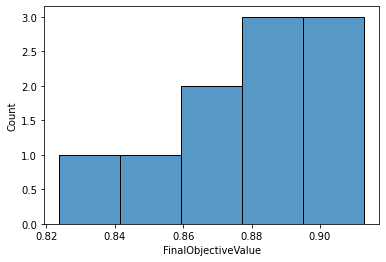

In [17]:
# Histogram of accuracy
sns.histplot(x=hp_results.FinalObjectiveValue);

## Evaluate model
### Make predictions
Let's get the test data and get the associated predictions from the Sagemaker endpoint we deployed in the previous step.

In [ ]:
from sagemaker.model import Model
import json

# Create model
# ============
model = Model(
    image_uri=image_uri,
    model_data=tuner.best_estimator().model_data,
    # name=model_name,
    sagemaker_session=session,
    role=role,
)
# model.create()  # Todo: Add tags


# Predict
# =======
transformer = tuner.best_estimator() \
    .transformer(
        instance_type=INSTANCE_TYPE_PREDICT,
        instance_count=INSTANCE_COUNT_BATCH_TRANSFORM,
        accept="application/jsonlines", # Only option for blazing text batch transform
        strategy='MultiRecord',
        assemble_with="Line",
        output_path=f"s3://{BUCKET}/predict-batch",
    )
transformer.transform(
    data=f's3://{BUCKET}/test',
    content_type='application/jsonlines',  # Only option for blazing text batch transform
    split_type='Line',
    join_source='Input',  # Join predictions with input data (for explainability)
    # experiment_config=None # Todo: Add
)
transformer.wait()  # This prints logs

In [75]:
# Save model name to be able to load it in other notebook
with open('data/model_name.pickle', 'wb') as file:
    pickle.dump(
        obj=transformer.model_name, 
        file=file
    )   

In [76]:
def retrieve_batch_predictions() -> pd.DataFrame:
    ## Todo: Use pydantic to guard against any schema change due to sagemaker 
    ## version update (and to increase readability). 
    ## Compare performance impact though.
    
    # Download predictions from s3
    local_path = 'data/predictions.json'
    s3_client.download_file(
        BUCKET,
        Key='predict-batch/model-input.jsonl.out',
        Filename=local_path,
    )

    # Read each row, convert to dict, then get fields needed
    prediction_rows = []
    with open(local_path, 'r') as file:
        # Keep reading next line until we hit end of file
        while True:
            line = file.readline()
            if line == '':
                logger.info('Finished reading file.')
                break
            else:
                row_dict = json.loads(line)
                
                probabilities = row_dict['SageMakerOutput']['prob']
                labels = row_dict['SageMakerOutput']['label']
                input_data = row_dict['source']
                true_label = row_dict['label']

                row = pd.Series(
                    probabilities + [true_label, input_data],
                    index=labels + ['true_label', 'input_data']
                )
                prediction_rows.append(row)

    # Once we have all rows, combine into DataFrame
    predictions = pd.DataFrame(prediction_rows)
    # Improve column names
    predictions.columns = predictions.columns.str.replace('__label__', 'p_')
    return predictions

predictions = retrieve_batch_predictions()
predictions.head(3)

,p_no_reply,p_reply,true_label,input_data
0,0.964495,0.035525,0,Good morning families - The technician is here...
1,0.626657,0.373363,0,[ http : //images.myhealthyfinances.com/Eloqua...
2,0.823848,0.176172,0,Warning : Low Battery Warning : Low Battery Vi...


In [104]:
# For explainability, use only a subset of test. TODO: oversample replied-tos.
THRESHOLD = 0.5
df_explain = predictions.sample(
    n=10,
    random_state=0, 
) \
[['p_reply', 'true_label', 'input_data']]
# .assign(
#     # predicted_label = (df_explain.p_reply > THRESHOLD).astype(int)
# )



           
path_local = 'data/model-input.csv'

# Using .to_csv() with a whitespace as a separator creates a normal text file
df_explain.to_csv(
    path_local,
    index=False, 
    header=True, 
    sep=',',
)

s3_client.upload_file(
    Filename=path_local,
    Bucket=BUCKET,
    Key=f'plaintext/explainability-input/model-input.csv'
)
    

# def _create_text_label(s):
#     """Convert 0/1 label to text"""
#     label = "reply" if s else "no_reply"
#     return f'__label__{label}'

In [110]:
# Todo: move this shared function to a utils moduleL

df_explain.rename(columns={'feature': 'source'}) \
    .to_json(orient='records', lines=True)

'{"p_reply":0.0000416842,"true_label":0,"input_data":"Thomas explore these courses on skills you follow Check out these recommendations and keep learning 5 top courses for skills youre interested in Save https : \\/\\/www.linkedin.com\\/comm\\/learning\\/algorithmic-thinking-with-python-diving-deeper ? save=true & amp ; midToken=AQGNE8E7EUEPVA & amp ; midSig=0AYocfTIiDaqs1 & amp ; trk=eml-email_learning_comms_related_to_skill_02-learning_recommendations-17-click_save_entity & amp ; trkEmail=eml-email_learning_comms_related_to_skill_02-learning_recommendations-17-click_save_entity-null-9avy5b % 7El8ekz98f % 7E2o-null-learning % 7Ecourse & amp ; lipi=urn % 3Ali % 3Apage % 3Aemail_email_learning_comms_related_to_skill_02 % 3BWwSqffMhRSS11Y2SVsDPPw % 3D % 3D COURSE Algorithmic Thinking with Python : Diving Deeper By : Robin Andrews ..................................... Save https : \\/\\/www.linkedin.com\\/comm\\/learning\\/programming-foundations-beyond-the-fundamentals ? save=true & midT

In [98]:
local_path = Path('data/model-input.jsonl')    
with local_path.open('w') as f:
    f.write(df_jsonl)

s3_client.upload_file(
    Filename=str(local_path),
    Bucket=BUCKET,
    Key=f'{destination_folder}/model-input.jsonl'
)

print(f'Data uploaded to {destination_folder}/model-input.jsonl')


write_jsonlines_to_s3(
df_explain, 
)

In [95]:
df_explain

,p_no_reply,p_reply,true_label,input_data,predicted_label
253,0.999978,0.000042,__label__no_reply,Thomas explore these courses on skills you fol...,False
541,0.834760,0.165259,__label__no_reply,The following SSH key was added to your accoun...,False
302,0.136947,0.863073,__label__no_reply,Dear Thomas Thank you for your interest in Ken...,True
3576,0.972343,0.027677,__label__no_reply,Malwarebytes www.malwarebytes.com ( https : //...,False
1698,0.827430,0.172590,__label__no_reply,Estimated to arrive Wed Apr 20 Order date : Su...,False
3049,0.991432,0.008588,__label__no_reply,https : //cl.S7.exct.net/ ? qs=30e68a195084d06...,False
2475,0.813780,0.186240,__label__no_reply,CarGurus Your wallet is going to love it . Wan...,False
841,0.626657,0.373363,__label__no_reply,[ http : //images.myhealthyfinances.com/Eloqua...,False
3616,0.951138,0.048882,__label__no_reply,See details about your credit report activity ...,False
473,0.842468,0.157552,__label__no_reply,Dear Thomas Loeber Hello < div > < br > < /div...,False


### Model performance

In [77]:
# AUC
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
roc_auc_score(y_true=predictions.true_label, y_score=predictions.p_reply)

0.8885168015572174

The AUC of .89 is pretty good, but  it can be misleading for an imbalanced classification problem (remember, we only oversampled the training and validation data). Thus, let's look at the confusion matrix for a more detailed view.

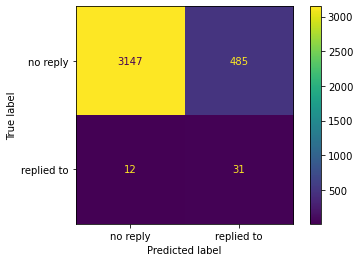

In [78]:
def create_confusion_matrix(predictions: pd.DataFrame, threshold: float) -> None:
    cm = confusion_matrix(
        y_true=predictions.true_label, 
        y_pred=predictions.p_reply > threshold
    )
    display = ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=['no reply', 'replied to']
    )
    display.plot()
    plt.show()
    
create_confusion_matrix(predictions, threshold = 0.5)

We see that if we just predict the most probable class, we can correctly predict about three quarters of replies. This is pretty good for predicting a rare event. Depending on what we care about, we could adjust the prediction threshold. For example, if we care about identifying messages that could potentially require a reply, we could flag each message that has a probability of reply greater than 20%. Let's see what results this gives us:

In [79]:
def create_classification_report(predictions: pd.DataFrame, threshold: float) -> None:
    report = classification_report(
        y_true=predictions.true_label, 
        y_pred=predictions.p_reply > threshold, 
        target_names=['no reply', 'replied to']
    )
    print(report)

create_classification_report(predictions, threshold = 0.5)

              precision    recall  f1-score   support

    no reply       1.00      0.87      0.93      3632
  replied to       0.06      0.72      0.11        43

    accuracy                           0.86      3675
   macro avg       0.53      0.79      0.52      3675
weighted avg       0.99      0.86      0.92      3675



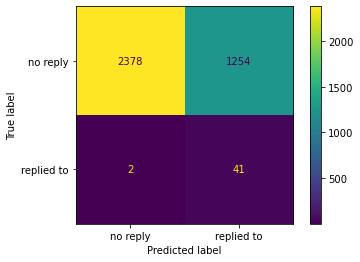

In [80]:
create_confusion_matrix(predictions, threshold = 0.2)

In [81]:
create_classification_report(predictions, 0.2)

              precision    recall  f1-score   support

    no reply       1.00      0.65      0.79      3632
  replied to       0.03      0.95      0.06        43

    accuracy                           0.66      3675
   macro avg       0.52      0.80      0.43      3675
weighted avg       0.99      0.66      0.78      3675



Now we are able to identify almost all emails eliciting a reply, at the cost of more false positives.

In [82]:
print(f'Finished at {datetime.now()}')

Finished at 2022-11-03 12:49:22.003167
